In [ ]:
import os
import gc
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torch.backends import cudnn

from src.val import val
from src.train import train
from src.models.resnexts import Model
from src.tools.pyutils import set_seed, save_file, load_file
from configurations.configs import get_configs
from src.datasets.VQAv1 import get_data_loader
from src.datasets.preparing import get_original_data
from src.preprocessing.data import (
    translate_data,
    remove_repeated_data,
    remove_english_qas
)
from src.preprocessing.questions import (
    tokenize_questions,
    get_tokens_length_frequency,
    filter_by_tokens_length,
    get_tokens_frequency,
    get_useful_tokens,
    get_tokens_dictionary
)
from src.preprocessing.annotations import (
    get_answers_frequency,
    get_k_frequent_answers,
    filter_by_k_frequent_answers,
    get_answers_dictionary
)
from src.tools.imgutils import extract_features
from src.tools.torchutils import get_class_weights

In [ ]:
# Enable CuDNN
cudnn.enabled = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Get Configurations
cfgs = get_configs()

In [ ]:
# Random State
set_seed(seed=cfgs['seed'])

In [ ]:
# Getting Original Data
original_data = get_original_data(cfgs=cfgs)
print('Getting Original Data:')
print(f'Train Data: {len(original_data["VQAv1"]["train"])}')
print(f'Val Data: {len(original_data["VQAv1"]["val"])}')

In [ ]:
# Split Train and Val Data
train_data = original_data["VQAv1"]["train"]
val_data = original_data["VQAv1"]["val"]
print('Analyzing Data ...')
print(f'Train Data: {len(train_data)}')
print(f'# Unique question_id: {len(set([d["question_id"] for d in train_data]))}')
print(f'# Unique image_id: {len(set([d["image_id"] for d in train_data]))}')
print(f'# Unique en_answer: {len(set([d["en_answer"] for d in train_data]))}')
print(f'# Unique en_question: {len(set([d["en_question"] for d in train_data]))}')
print(f'# Unique (A, Q): {len(set([(d["en_answer"], d["en_question"]) for d in train_data]))}')
print(f'# Unique (A, Q, I): {len(set([(d["en_answer"], d["en_question"], d["image_id"]) for d in train_data]))}')

In [ ]:
# Translate Data:
train_data = translate_data(
    data=train_data,
    save_path=cfgs['preprocess']['root_path'],
    dictionary_name=cfgs['preprocess']['dictionary_name']
)
print(f'Train Data: {len(train_data)}')
print(f'# Unique question_id: {len(set([d["question_id"] for d in train_data]))}')
print(f'# Unique image_id: {len(set([d["image_id"] for d in train_data]))}')
print(f'# Unique fa_answer: {len(set([d["fa_answer"] for d in train_data]))}')
print(f'# Unique fa_question: {len(set([d["fa_question"] for d in train_data]))}')
print(f'# Unique (A, Q): {len(set([(d["fa_answer"], d["fa_question"]) for d in train_data]))}')
print(f'# Unique (A, Q, I): {len(set([(d["fa_answer"], d["fa_question"], d["image_id"]) for d in train_data]))}')

In [ ]:
# Removing repeated data:
train_data = remove_repeated_data(data=train_data)
print('After removing repeated data ...')
print(f'Train Data: {len(train_data)}')
print(f'# Unique question_id: {len(set([d["question_id"] for d in train_data]))}')
print(f'# Unique image_id: {len(set([d["image_id"] for d in train_data]))}')
print(f'# Unique fa_answer: {len(set([d["fa_answer"] for d in train_data]))}')
print(f'# Unique fa_question: {len(set([d["fa_question"] for d in train_data]))}')
print(f'# Unique (A, Q): {len(set([(d["fa_answer"], d["fa_question"]) for d in train_data]))}')
print(f'# Unique (A, Q, I): {len(set([(d["fa_answer"], d["fa_question"], d["image_id"]) for d in train_data]))}')

In [ ]:
# Remove English questions and answers if exists
train_data = remove_english_qas(data=train_data)
print(f'After removing english questions and answers: {len(train_data)}')
print(f'Train Data: {len(train_data)}')
print(f'# Unique question_id: {len(set([d["question_id"] for d in train_data]))}')
print(f'# Unique image_id: {len(set([d["image_id"] for d in train_data]))}')
print(f'# Unique fa_answer: {len(set([d["fa_answer"] for d in train_data]))}')
print(f'# Unique fa_question: {len(set([d["fa_question"] for d in train_data]))}')
print(f'# Unique (A, Q): {len(set([(d["fa_answer"], d["fa_question"]) for d in train_data]))}')
print(f'# Unique (A, Q, I): {len(set([(d["fa_answer"], d["fa_question"], d["image_id"]) for d in train_data]))}')

In [ ]:
# Validation
## Translating
print(f'Val Data: {len(val_data)}')
print(f'# Unique (A, Q, I): {len(set([(d["en_answer"], d["en_question"], d["image_id"]) for d in val_data]))}')

val_data = translate_data(
    data=val_data,
    save_path=cfgs['preprocess']['root_path'],
    dictionary_name=cfgs['preprocess']['dictionary_name']
)
print(f'Val Data: {len(val_data)}')
print(f'# Unique (A, Q, I): {len(set([(d["fa_answer"], d["fa_question"], d["image_id"]) for d in val_data]))}')

val_data = remove_repeated_data(data=val_data)
print(f'Val Data: {len(val_data)}')
print(f'# Unique (A, Q, I): {len(set([(d["fa_answer"], d["fa_question"], d["image_id"]) for d in val_data]))}')

val_data = remove_english_qas(data=val_data)
print(f'Val Data: {len(val_data)}')
print(f'# Unique (A, Q, I): {len(set([(d["fa_answer"], d["fa_question"], d["image_id"]) for d in val_data]))}')

In [ ]:
# Filter data by k frequent answers
dataset = train_data + val_data
print(f'Dataset: {len(dataset)}')

answers_frequency = get_answers_frequency(data=dataset)
print(f'Number of unique answers: {len(answers_frequency)}')

k_frequent_answers = get_k_frequent_answers(answers_frequency=answers_frequency, k=1000)

print(f'{len(k_frequent_answers)}/{len(answers_frequency)} = {len(k_frequent_answers) / len(answers_frequency)}')
print(f'{sum([v for k, v in k_frequent_answers.items()])}/{len(dataset)} = '
      f'{(sum([v for k, v in k_frequent_answers.items()]))/len(dataset)}')
print(f'Max: {max(k_frequent_answers.items(), key=lambda x: x[1])}')
print(f'Min: {min(k_frequent_answers.items(), key=lambda x: x[1])}')

train_data = filter_by_k_frequent_answers(data=train_data, answers=k_frequent_answers)
print('After filtering by k frequent answers ...')
print(f'Train Data: {len(train_data)}')
print(f'# Unique question_id: {len(set([d["question_id"] for d in train_data]))}')
print(f'# Unique image_id: {len(set([d["image_id"] for d in train_data]))}')
print(f'# Unique fa_answer: {len(set([d["fa_answer"] for d in train_data]))}')
print(f'# Unique fa_question: {len(set([d["fa_question"] for d in train_data]))}')
print(f'# Unique (A, Q): {len(set([(d["fa_answer"], d["fa_question"]) for d in train_data]))}')
print(f'# Unique (A, Q, I): {len(set([(d["fa_answer"], d["fa_question"], d["image_id"]) for d in train_data]))}')

In [ ]:
# Preprocessing Train Data
## Step 1: Preprocessing Questions
### Tokenize Questions
train_data = tokenize_questions(data=train_data)
tokens_length_frequency = get_tokens_length_frequency(data=train_data)
print(f'Tokens Length Freqs: {tokens_length_frequency}')
print(f'Train Data: {len(train_data)}')
print(f'# Unique question_id: {len(set([d["question_id"] for d in train_data]))}')
print(f'# Unique image_id: {len(set([d["image_id"] for d in train_data]))}')
print(f'# Unique fa_answer: {len(set([d["fa_answer"] for d in train_data]))}')
print(f'# Unique fa_question: {len(set([d["fa_question"] for d in train_data]))}')
print(f'# Unique tokens: {len(set([t for d in train_data for t in d["tokens"]]))}')
print(f'# Unique (A, T): {len(set([(d["fa_answer"], tuple(d["tokens"])) for d in train_data]))}')
print(f'# Unique (A, T, I): {len(set([(d["fa_answer"], tuple(d["tokens"]), d["image_id"]) for d in train_data]))}')

In [ ]:
### Limit Questions by length
tokens_length = 20
train_data = filter_by_tokens_length(data=train_data, tokens_length=tokens_length)
print(f'Train Data: {len(train_data)}')
print(f'# Unique question_id: {len(set([d["question_id"] for d in train_data]))}')
print(f'# Unique image_id: {len(set([d["image_id"] for d in train_data]))}')
print(f'# Unique fa_answer: {len(set([d["fa_answer"] for d in train_data]))}')
print(f'# Unique fa_question: {len(set([d["fa_question"] for d in train_data]))}')
print(f'# Unique tokens: {len(set([t for d in train_data for t in d["tokens"]]))}')
print(f'# Unique (A, T): {len(set([(d["fa_answer"], tuple(d["tokens"])) for d in train_data]))}')
print(f'# Unique (A, T, I): {len(set([(d["fa_answer"], tuple(d["tokens"]), d["image_id"]) for d in train_data]))}')

In [ ]:
### Filter Questions by k frequents words (tokens)
tokens_frequency = get_tokens_frequency(data=train_data)
print(f'Number of unique tokens: {len(tokens_frequency)}')

In [ ]:
min_occ = 5
useful_tokens = get_useful_tokens(tokens_frequency=tokens_frequency, min_occ=min_occ)
print(f'{len(useful_tokens)}/{len(tokens_frequency)} = {len(useful_tokens) / len(tokens_frequency)}')
print(f'{sum([v for k, v in useful_tokens.items()])}/{sum([v for k, v in tokens_frequency.items()])} = '
      f'{(sum([v for k, v in useful_tokens.items()]))/(sum([v for k, v in tokens_frequency.items()]))}')

In [ ]:
# Final Preparation
idx_to_token, token_to_idx = get_tokens_dictionary(
    useful_tokens=useful_tokens,
    save_path=cfgs['preprocess']['root_path'],
    idx_to_token_save_name=cfgs['preprocess']['idx_to_token'],
    token_to_idx_save_name=cfgs['preprocess']['token_to_idx'],
)
idx_to_answer, answer_to_idx = get_answers_dictionary(
    answers=k_frequent_answers,
    save_path=cfgs['preprocess']['root_path'],
    idx_to_answer_save_name=cfgs['preprocess']['idx_to_answer'],
    answer_to_idx_save_name=cfgs['preprocess']['answer_to_idx'],
)

print(f'Token Dictionary: {len(token_to_idx)}')
print(f'Answer Dictionary: {len(answer_to_idx)}')

In [ ]:
# Preprocessing Validation Data:
val_data = filter_by_k_frequent_answers(data=val_data, answers=k_frequent_answers)
val_data = tokenize_questions(data=val_data)
val_data = filter_by_tokens_length(data=val_data, tokens_length=tokens_length)

In [ ]:
print(f'# Unique fa_answer: {len(set([d["fa_answer"] for d in val_data]))}')

In [ ]:
# Extract Features:
train_trans = T.Compose([
    T.ToTensor(),
    T.Resize(size=(224, 224)),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_trans = T.Compose([
    T.ToTensor(),
    T.Resize(size=(224, 224)),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_data = extract_features(
    data=train_data,
    trans=train_trans,
    device=device,
    save_path=cfgs['preprocess']['image_features']
)

val_data = extract_features(
    data=val_data,
    trans=val_trans,
    device=device,
    save_path=cfgs['preprocess']['image_features']
)

In [ ]:
# Preparing Datasets and Dataloaders:
trainloader = get_data_loader(
    data=train_data,
    token_to_idx=token_to_idx,
    answer_to_idx=answer_to_idx,
    tokens_length=tokens_length,
    trans=train_trans,
    batch_size=cfgs['batch_size'],
    shuffle=True
)
valloader = get_data_loader(
    data=val_data,
    token_to_idx=token_to_idx,
    answer_to_idx=answer_to_idx,
    tokens_length=tokens_length,
    trans=val_trans,
    batch_size=cfgs['batch_size'],
    shuffle=False
)

# Preparing Model:

In [ ]:
gc.collect()
torch.cuda.empty_cache()

model = Model(
    vocabulary_size=len(token_to_idx) + 1,  # +1 for padding
    num_classes=len(answer_to_idx),
    tokens_length=tokens_length,
    hidden_size=512,
    embed_dim=512,
    dropout=0.30,
)

# Training:

In [ ]:
best_loss = np.inf
optimizer = torch.optim.Adam(params=model.parameters(), lr=cfgs['lr'])
criterion = torch.nn.CrossEntropyLoss()
model = model.to(device=device)
train_batch_global_step = 1
val_batch_global_step = 1
history = {
    'train_accuracy': [],
    'train_loss': [],
    'val_accuracy': [],
    'val_loss': []
}

for i in range(cfgs['epochs']):
    print(f'Epoch: {i+1}')
    
    model, train_scores, train_batch_global_step = train(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        dataloader=trainloader,
        device=device,
        global_step=train_batch_global_step
    )
    history['train_accuracy'].append(train_scores['accuracy'])
    history['train_loss'].append(train_scores['loss'])
    
    
    val_scores, val_batch_global_step = val(
        model=model,
        criterion=criterion,
        dataloader=valloader,
        device=device,
        global_step=val_batch_global_step
    )
    history['val_accuracy'].append(val_scores['accuracy'])
    history['val_loss'].append(val_scores['loss'])
    
    if train_scores['loss'] < best_loss:
        best_loss = train_scores['loss']
        save_file(data=history, path=cfgs['root_path'], file_name=f'History_{i+1}.pickle')
        torch.save(obj=model.state_dict(), f=os.path.join(cfgs['root_path'], f'Model_{i+1}.pth'))

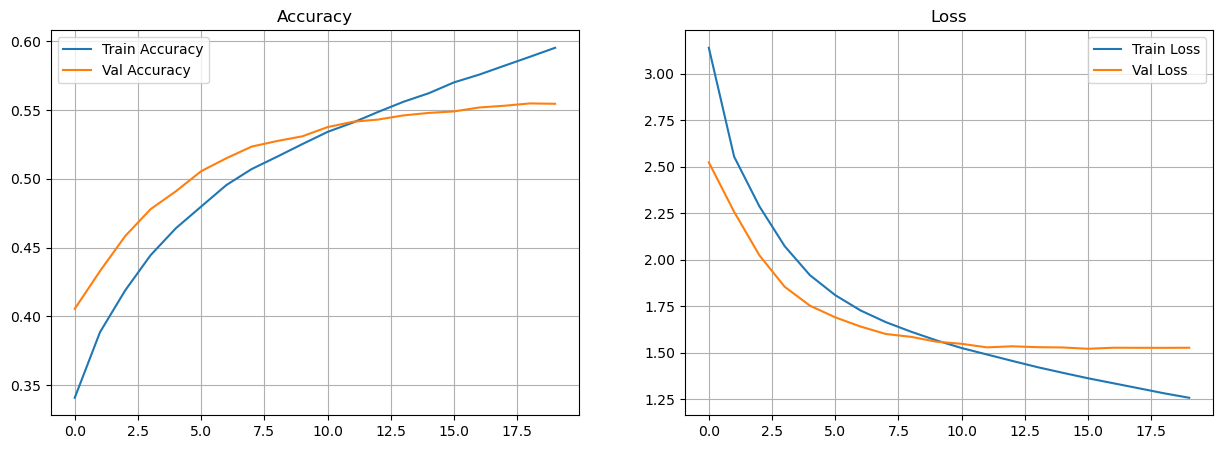

In [4]:
history = load_file(path=os.path.join(cfgs['root_path'], 'History_E20.pickle'))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(history['train_accuracy'], label='Train Accuracy')
axes[0].plot(history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Accuracy')
axes[0].grid()
axes[0].legend()

axes[1].plot(history['train_loss'], label='Train Loss')
axes[1].plot(history['val_loss'], label='Val Loss')
axes[1].set_title('Loss')
axes[1].grid()
axes[1].legend()
plt.show()

In [6]:
history

{'train_accuracy': [0.3406812846660614,
  0.3884430527687073,
  0.4189313054084778,
  0.4444094598293304,
  0.4640249013900757,
  0.479796826839447,
  0.4954825341701507,
  0.5071128606796265,
  0.516045093536377,
  0.5252202749252319,
  0.5341233611106873,
  0.5408878922462463,
  0.5486656427383423,
  0.5560287237167358,
  0.5622385144233704,
  0.5701478719711304,
  0.5758049488067627,
  0.5823106169700623,
  0.5887547731399536,
  0.5953269600868225],
 'train_loss': [3.1402852535247803,
  2.5543854236602783,
  2.286781072616577,
  2.0723705291748047,
  1.9160772562026975,
  1.8086481094360352,
  1.7264326810836792,
  1.6634734869003296,
  1.611862063407898,
  1.5653432607650757,
  1.5239851474761963,
  1.489313006401062,
  1.454764723777771,
  1.4210610389709473,
  1.3906954526901243,
  1.3612385988235474,
  1.3344496488571167,
  1.3076236248016355,
  1.28053617477417,
  1.2562882900238037],
 'val_accuracy': [0.405375757217407,
  0.432895102500915,
  0.458411523103714,
  0.47791225552

# Try:

In [1]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms as T

from configurations.configs import get_configs
from src.preprocessing.questions import tokenize_questions, filter_by_tokens_length
from src.tools.pyutils import load_file
from src.models.resnexts import Model, FeatureExtractor

In [3]:
cfgs = get_configs()

In [3]:
def predict(image_path, question, model, token_to_idx, answer_to_idx, idx_to_answer, tokens_length, max_ans=5):
    FE = FeatureExtractor()
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    trans = T.Compose([
        T.ToTensor(),
        T.Resize(size=(224, 224)),
#         T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    img = trans(img).unsqueeze(0)
    img_fea = FE(img)
    
    q = [{'fa_question': question}]
    q = tokenize_questions(q)
    q = filter_by_tokens_length(q, tokens_length)
    q = q[0]['tokens']

    question = torch.zeros(size=(tokens_length, ), dtype=torch.long)
    for i in range(len(q)):
        if i < tokens_length:
            question[i] = token_to_idx.get(q[i], token_to_idx['UKN'])
    question = question.unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        pred = model(img_fea, question)[0]
    pred = torch.softmax(pred, dim=0)
    
    answers = torch.topk(input=pred, dim=0, k=max_ans)

    for i in range(max_ans):
        print(f'Answer {i+1}: {idx_to_answer[answers[1][i].item()]}, Probability: {answers[0][i].item()}')

In [4]:
weights_path = 'Model_20.pth'
token_to_idx = load_file(path=os.path.join(cfgs['preprocess']['root_path'], cfgs['preprocess']['token_to_idx']))
answer_to_idx = load_file(path=os.path.join(cfgs['preprocess']['root_path'], cfgs['preprocess']['answer_to_idx']))
idx_to_answer = load_file(path=os.path.join(cfgs['preprocess']['root_path'], cfgs['preprocess']['idx_to_answer']))
tokens_length = 20

model = Model(
    vocabulary_size=len(token_to_idx) + 1,  # +1 for padding
    num_classes=len(answer_to_idx),
    tokens_length=tokens_length,
    hidden_size=512,
    embed_dim=512,
    dropout=0,
)

weights = torch.load(weights_path)
model.load_state_dict(weights)

<All keys matched successfully>

In [45]:
# It Should be in test_images path in root
image_path = 'test_images/3.jpg'
question = 'گربه چه رنگی است؟'

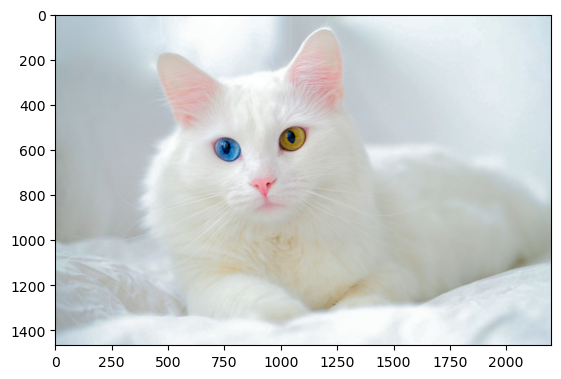

Answer 1: سیاه و سفید, Probability: 0.3166128695011139
Answer 2: سیاه, Probability: 0.24730606377124786
Answer 3: خاکستری, Probability: 0.17277853190898895
Answer 4: سفید, Probability: 0.0815940573811531
Answer 5: رنگ قهوه ای, Probability: 0.05505356937646866


In [46]:
predict(image_path, question, model, token_to_idx, answer_to_idx, idx_to_answer, tokens_length)